In [ ]:
!pip install fredapi
!pip install statsmodels
!pip install yfinance
!pip install scipy

In [ ]:
import fredapi
from fredapi import Fred
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import *
import statsmodels.api as sm
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
%load_ext rpy2.ipython

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%%R
install.packages(c("portes", "vars", "tseries", "fracdiff", "tsoutliers"))
library("portes")
library("vars")
library("tseries")
library("fracdiff")
library("tsoutliers")

# Time series analysis

### Let's start with downloading some data. I've chosen NASDAQ prices for between 1980 and 1990:

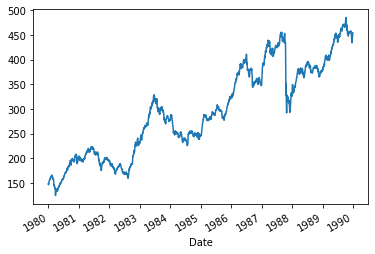

In [ ]:
data = yf.Ticker("^IXIC").history(start="1980-01-01", end="1990-01-01")["Close"]
data.plot()

### Right in the beginning, let us check if the series has got long or medium memory:

In [ ]:
%%R -i data
fracdiff::fdGPH(data)

$d
[1] 1.048073

$sd.as
[1] 0.1030489

$sd.reg
[1] 0.06441132



### The parameter d is bigger than 0.5 - it contains no long nor medium memory, so we can proceed. Now it is necessary to check, if the downloaded series is stationary. I will do that by carrying out the ADF and KPSS tests. The series will be considered as stationary only if both of the tests prove stationary:

In [ ]:
%%R -i data
print(adf.test(as.ts(data)))
print(kpss.test(as.ts(data)))


	Augmented Dickey-Fuller Test

data:  as.ts(data)
Dickey-Fuller = -2.862, Lag order = 13, p-value = 0.2134
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(data)
KPSS Level = 24.765, Truncation lag parameter = 8, p-value = 0.01



### The series is not stationary. In such case I will consider differenced returns and log returns, the most appropriate one will be chosen at the end of the analysis:

In [ ]:
returns = data.diff(1)[1:]
log_returns = np.log(data).diff(1)[1:]

In [ ]:
%%R -i returns
print(adf.test(as.ts(returns)))
print(kpss.test(as.ts(returns)))


	Augmented Dickey-Fuller Test

data:  as.ts(returns)
Dickey-Fuller = -12.179, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(returns)
KPSS Level = 0.03595, Truncation lag parameter = 8, p-value = 0.1



In [ ]:
%%R -i log_returns
print(adf.test(as.ts(log_returns)))
print(kpss.test(as.ts(log_returns)))


	Augmented Dickey-Fuller Test

data:  as.ts(log_returns)
Dickey-Fuller = -11.691, Lag order = 13, p-value = 0.01
alternative hypothesis: stationary


	KPSS Test for Level Stationarity

data:  as.ts(log_returns)
KPSS Level = 0.061716, Truncation lag parameter = 8, p-value = 0.1



### As shown above, both of the returns are stationary. In such case, let's start with analysing the distributions:

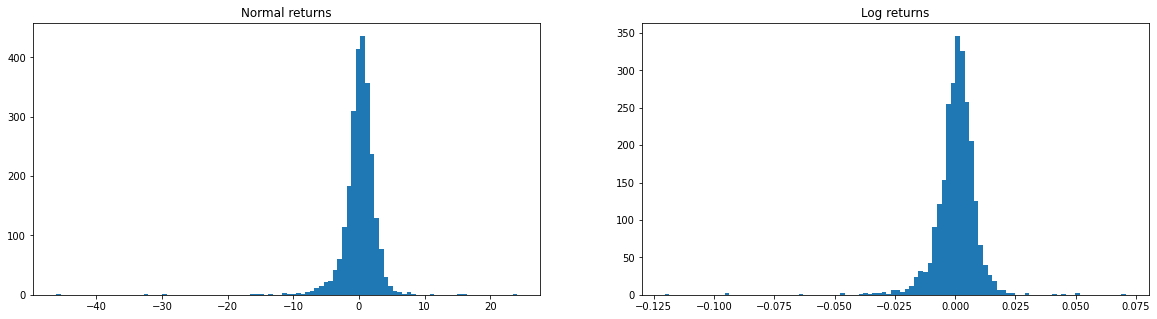

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].hist(returns, bins=100)
ax[0].title.set_text("Normal returns")

ax[1].hist(log_returns, bins=100)
ax[1].title.set_text("Log returns")

plt.show()

### The distributions do not seem to have more than one peak, and they appear to have heavy tails. The next step will be checking qqplots:

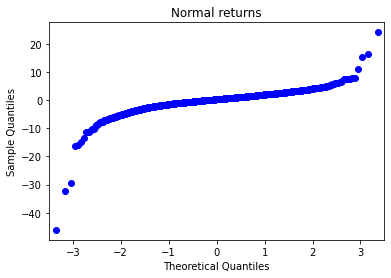

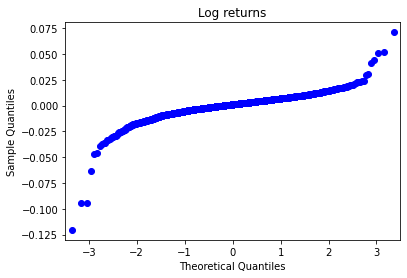

In [ ]:
sm.qqplot(returns)
plt.title("Normal returns")
plt.show()
sm.qqplot(log_returns)
plt.title("Log returns")
plt.show()

### As expected, the qqplots also show heavy tails, with a little bit of skewness - the series tends to have more extreme negative returns than positive. Let us calculate the kurtosis and skewness then:

In [ ]:
res = pd.DataFrame({"Kurtosis": [kurtosis(returns), kurtosis(log_returns)], "Skewness": [skew(returns), skew(log_returns)]}, index=["returns", "log returns"])
res

,Kurtosis,Skewness
returns,61.293992,-3.787063
log returns,32.077602,-2.422380


### Log returns clearly show skewness and kurtosis closer to normal distribution. In such case I will check their normality using Jarque-Bera test:

In [ ]:
%%R
print("Normal returns: ")
print(jarque.bera.test(returns))
print("-------------------------------")
print("Log returns: ")
print(jarque.bera.test(log_returns))

[1] "Normal returns: "

	Jarque Bera Test

data:  returns
X-squared = 401616, df = 2, p-value < 2.2e-16

[1] "-------------------------------"
[1] "Log returns: "

	Jarque Bera Test

data:  log_returns
X-squared = 110814, df = 2, p-value < 2.2e-16



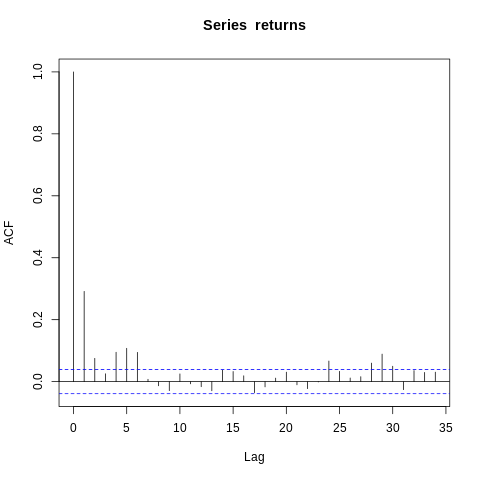

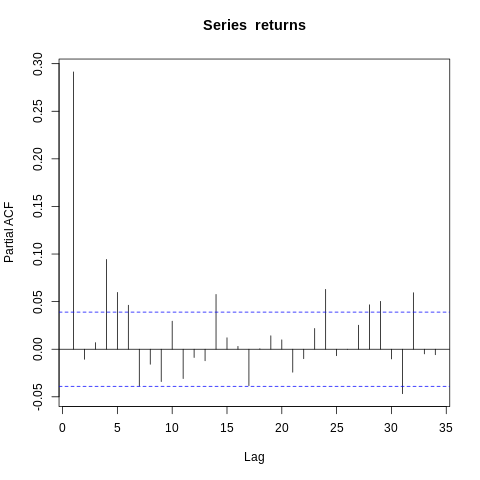

In [ ]:
%%R

acf(returns)
pacf(returns)

### Both of the returns reject null hypothesis, the distribution is not normal. Nevertheless it's worth noting, that the chi-squared statistic in case of log returns is smaller. I'm going to check now the autocorrelations and partial autocorrelations using ACF, PACF and Ljung-Box tests:

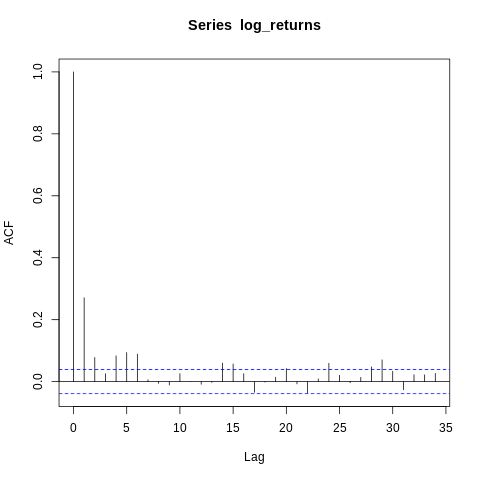

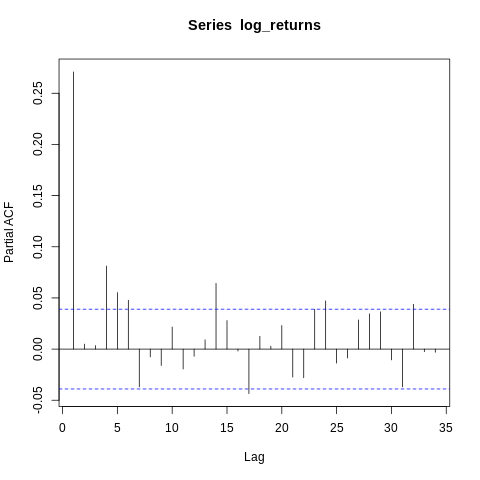

In [ ]:
%%R

acf(log_returns)
pacf(log_returns)

###It's worth noting that the plots above suggest seasonality

In [ ]:
%%R
print(LjungBox(returns))
print(LjungBox(log_returns))

 lags statistic df p-value
    5  282.7944  5       0
   10  309.7427 10       0
   15  318.9727 15       0
   20  326.5463 20       0
   25  342.2489 25       0
   30  378.9309 30       0
 lags statistic df p-value
    5  242.5910  5       0
   10  264.7380 10       0
   15  282.2374 15       0
   20  291.9969 20       0
   25  305.9261 25       0
   30  327.7248 30       0


###Both types of returns show statistically significant autocorrelations and partial autocorrelations. Since we've confirmed linear relationships, let's test for quadriatic autocorrelation (ARCH effect), and let's visualise it:

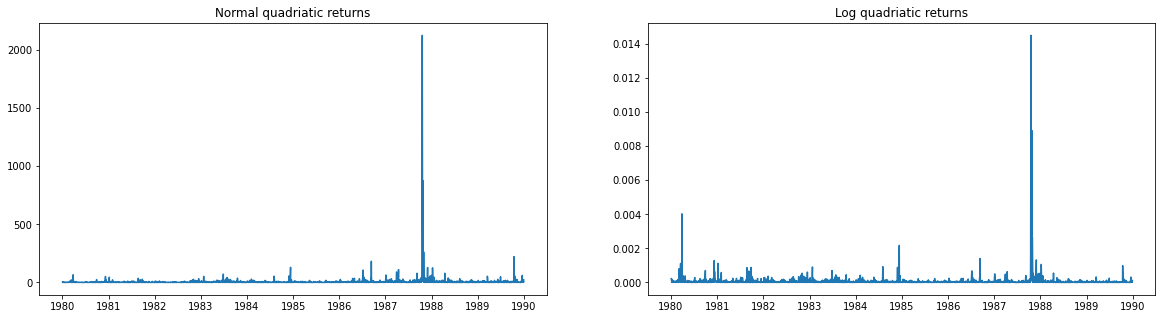

In [ ]:
q_returns = returns ** 2
q_log_returns = log_returns ** 2

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(q_returns)
ax[0].title.set_text("Normal quadriatic returns")

ax[1].plot(q_log_returns)
ax[1].title.set_text("Log quadriatic returns")

plt.show()

###The plots suggest, that there possibly might be some conditional heteroskedasticity. Let's confirm it with additional tests:

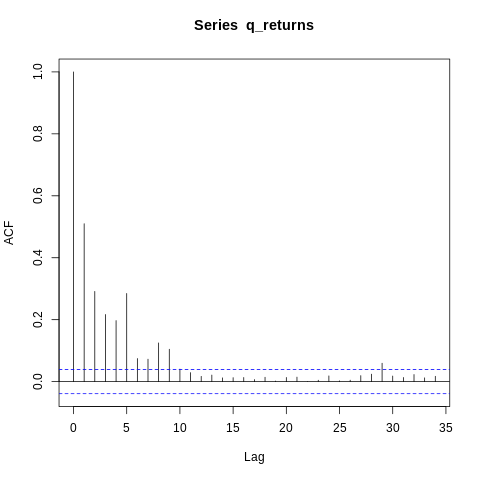

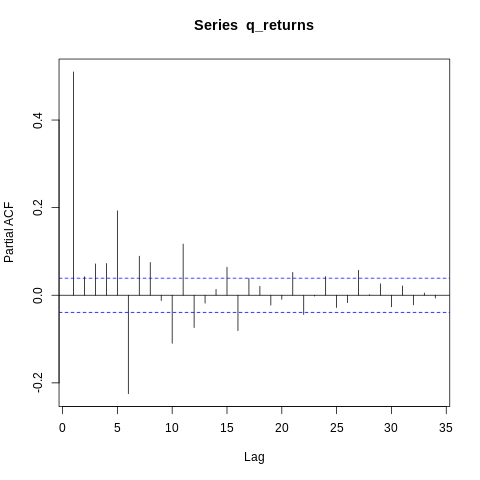

In [ ]:
%%R -i q_returns

acf(q_returns)
pacf(q_returns)

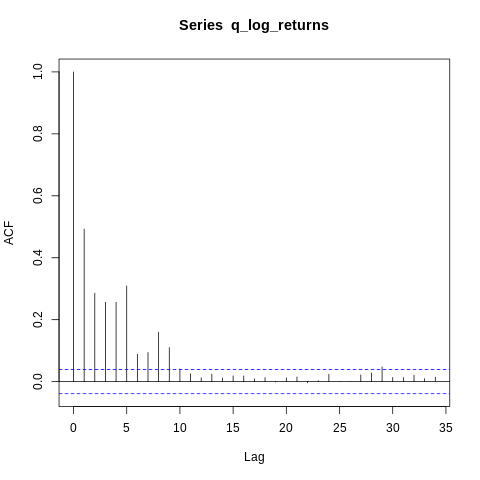

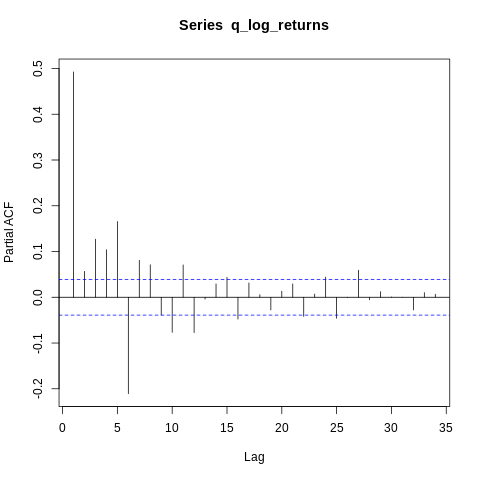

In [ ]:
%%R -i q_log_returns

acf(q_log_returns)
pacf(q_log_returns)

###The ACF and PACF suggest there indeed might be some conditional heteroscedasticity. Let's now confirm it with Ljung-Box test with the preassumption of the mean equal to 0:

In [ ]:
%%R

print(LjungBox(q_returns))
print(LjungBox(q_log_returns))

 lags statistic df p-value
    5  1294.840  5       0
   10  1393.752 10       0
   15  1398.569 15       0
   20  1400.111 20       0
   25  1401.600 25       0
   30  1413.990 30       0
 lags statistic df p-value
    5  1394.977  5       0
   10  1536.629 10       0
   15  1541.400 15       0
   20  1543.286 20       0
   25  1545.355 25       0
   30  1554.791 30       0


##Ljung-Box test has confrimed, that there is a quadriatic relationship in the series. The Engle's ARCH test will be covered in another section, dedicated to volatility. Since it has been confirmed, that log returns present better statistical features, normal returns will not be taken into account in any further analysis.